# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import matplotlib
from scipy.interpolate import griddata
# Disable scientific notation
np.set_printoptions(suppress=True)
import laspy
import open3d as o3d
import json
from scipy.spatial.transform import Rotation as R


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#

In [2]:
las = laspy.read("output.las")

# Extract 3D points and normalize intensity
points = np.vstack((las.x, las.y, las.z)).T  # Shape: (N, 3)
intensities = las.intensity / 65535.0        # Normalize to [0, 1]

print(f"Loaded {points.shape[0]} points.")

Loaded 132661978 points.


In [4]:
las = laspy.read("output.las")

# Optional: Downsample (e.g., first 1 million points)
N = min(len(las.x), 1_000_000)

x = las.x[:N]
y = las.y[:N]
z = las.z[:N]
points = np.vstack((x, y, z)).T

# Step 2: Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optional: Add color using normalized intensity
if hasattr(las, 'intensity'):
    intensities = las.intensity[:N] / 65535.0  # Normalize
    colors = np.tile(intensities[:, None], (1, 3))  # grayscale to RGB
    pcd.colors = o3d.utility.Vector3dVector(colors)

# Step 3: Visualize
o3d.visualization.draw_geometries([pcd])

In [9]:
with open("output.laz.index.json") as f:
    index_data = json.load(f)
entries = index_data["entries"]

# Extract camera timestamp from filename
image_ts = 49101816

# Find the closest LiDAR scan to that timestamp
closest_entry = min(
    entries,
    key=lambda e: abs((e["start_ts"] + e["end_ts"]) / 2 - image_ts)
)

# Read LAS file (already converted from LAZ)
las = laspy.read("output.las")

# Extract the scan slice
offset = closest_entry["point_offset_in_file"]
count = closest_entry["num_pts"]

x = las.x[offset:offset + count]
y = las.y[offset:offset + count]
z = las.z[offset:offset + count]
points = np.vstack((x, y, z)).T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optional: add intensity as grayscale color
if hasattr(las, 'intensity'):
    intensity = las.intensity[offset:offset + count] / 65535.0  # Normalize
    colors = np.tile(intensity[:, None], (1, 3))  # grayscale to RGB
    pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([
    pcd,
    o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
])

In [4]:
image_name = "cam_0_49101816.jpg"
image_ts = int(image_name.split('_')[2].split('.jpg')[0])
las = laspy.read("output.las")
print(list(las.point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time']


In [5]:
import laspy
import numpy as np
import pandas as pd
import json

# Step 1: Load the index file
with open("output.laz.index.json") as f:
    index_data = json.load(f)

entries = index_data["entries"]

# Step 2: Extract timestamp from camera image name
image_name = "cam_0_49101816.jpg"
image_ts = int(image_name.split("_")[2].split(".")[0])  # Extract 49101816

# Step 3: Find closest LiDAR scan to the image timestamp
closest_entry = min(
    entries,
    key=lambda e: abs((e["start_ts"] + e["end_ts"]) / 2 - image_ts)
)

# Step 4: Read the corresponding scan from the .las file
las = laspy.read("output.las")

offset = closest_entry["point_offset_in_file"]
count = closest_entry["num_pts"]

# Extract point coordinates
x = las.x[offset:offset + count]
y = las.y[offset:offset + count]
z = las.z[offset:offset + count]

# Optional: extract intensity if present
if hasattr(las, 'intensity'):
    intensity = las.intensity[offset:offset + count] / 65535.0
    df = pd.DataFrame({
        "X": x,
        "Y": y,
        "Z": z,
        "intensity": intensity
    })
else:
    df = pd.DataFrame({
        "X": x,
        "Y": y,
        "Z": z
    })

# ✅ Done: You now have a DataFrame of the LiDAR points for that camera timestamp
print(df.head())

points = np.vstack((x, y, z)).T  # X, Y, Z as columns

# Create DataFrame properly
df = pd.DataFrame(points, columns=["X", "Y", "Z"])

# Add intensity if available
if intensity is not None:
    df["intensity"] = intensity


                                                   X  \
0  [95.33668359865322, 95.22938359865321, 95.0967...   
1  [95.33668359865322, 95.22938359865321, 95.0967...   
2  [95.33668359865322, 95.22938359865321, 95.0967...   
3  [95.33668359865322, 95.22938359865321, 95.0967...   
4  [95.33668359865322, 95.22938359865321, 95.0967...   

                                                   Y  \
0  [-31.733261651628297, -31.913741651628293, -32...   
1  [-31.733261651628297, -31.913741651628293, -32...   
2  [-31.733261651628297, -31.913741651628293, -32...   
3  [-31.733261651628297, -31.913741651628293, -32...   
4  [-31.733261651628297, -31.913741651628293, -32...   

                                                   Z  intensity  
0  [20.436823482319124, 20.415823482319123, 20.38...   0.109804  
1  [20.436823482319124, 20.415823482319123, 20.38...   0.078431  
2  [20.436823482319124, 20.415823482319123, 20.38...   0.062745  
3  [20.436823482319124, 20.415823482319123, 20.38...   0.07058

## Extract Matrices

In [66]:
with open('output.laz.trajectory.json', 'r') as m :
    matrices = json.load(m)

# Camera 0 
cx , cy = matrices['camera_infos']['cam_0']['cx'], matrices['camera_infos']['cam_0']['cy']
fx , fy = matrices['camera_infos']['cam_0']['fx'], matrices['camera_infos']['cam_0']['fy']

qw, qx, qy, qz = matrices['sensor_to_trajectory_poses']['cam_0'][3:]
tx, ty, tz = matrices['sensor_to_trajectory_poses']['cam_0'][0:3]

quat = [qx, qy, qz, qw]  # scipy uses (x, y, z, w)
R_matrix = R.from_quat(quat).as_matrix()  # Converts quaternion to 3x3 rotation matrix

T_matrix_cam_to_rig = np.zeros(shape=(3,4))
T_matrix_cam_to_rig[:3,:3] = R_matrix
T_matrix_cam_to_rig[:,3] = [tx ,ty, tz]

T_matrix_cam_to_rig = np.vstack((T_matrix_cam_to_rig, [0, 0, 0, 1]))
T_matrix_rig_to_cam = np.linalg.inv(T_matrix_cam_to_rig)

K_matrix = np.zeros(shape=(3,3))
K_matrix[0,0], K_matrix[1,1] = fx, fy
K_matrix[0,2], K_matrix[1,2] = cx, cy 
K_matrix[2,2] = 1

# Camera 1
c1cx , c1cy = matrices['camera_infos']['cam_1']['cx'], matrices['camera_infos']['cam_1']['cy']
c1fx , c1fy = matrices['camera_infos']['cam_1']['fx'], matrices['camera_infos']['cam_1']['fy']

c1qw, c1qx, c1qy, c1qz = matrices['sensor_to_trajectory_poses']['cam_1'][3:]
c1tx, c1ty, c1tz = matrices['sensor_to_trajectory_poses']['cam_1'][0:3]

quat_c1 = [c1qx, c1qy, c1qz, c1qw]  # scipy uses (x, y, z, w)
R_matrix_c1 = R.from_quat(quat_c1).as_matrix()  # Converts quaternion to 3x3 rotation matrix

T_matrix_cam1_to_rig = np.zeros(shape=(3,4))
T_matrix_cam1_to_rig[:3,:3] = R_matrix
T_matrix_cam1_to_rig[:,3] = [tx ,ty, tz]

T_matrix_cam1_to_rig = np.vstack((T_matrix_cam1_to_rig, [0, 0, 0, 1]))
T_matrix_rig_to_cam1 = np.linalg.inv(T_matrix_cam1_to_rig)

K_matrix_c1 = np.zeros(shape=(3,3))
K_matrix_c1[0,0], K_matrix[1,1] = c1fx, c1fy
K_matrix_c1[0,2], K_matrix[1,2] = c1cx, c1cy 
K_matrix_c1[2,2] = 1

# Lidar front
qw, qx, qy, qz = matrices['sensor_to_trajectory_poses']['laser_0'][3:]
tx, ty, tz = matrices['sensor_to_trajectory_poses']['laser_0'][0:3]

quat = [qx, qy, qz, qw]  # scipy uses (x, y, z, w)
R_matrix_lidar = R.from_quat(quat).as_matrix()  # Converts quaternion to 3x3 rotation matrix

T_matrix_lidar_to_rig = np.zeros(shape=(3,4))
T_matrix_lidar_to_rig[:3,:3] = R_matrix_lidar
T_matrix_lidar_to_rig[:,3] = [tx ,ty, tz]
T_matrix_lidar_to_rig = np.vstack((T_matrix_lidar_to_rig, [0, 0, 0, 1]))
T_matrix_rig_to_lidar = np.linalg.inv(T_matrix_lidar_to_rig)

# Lidar back
qwl1, qxl1, qyl1, qzl1 = matrices['sensor_to_trajectory_poses']['laser_1'][3:]
txl1, tyl1, tzl1 = matrices['sensor_to_trajectory_poses']['laser_1'][0:3]

quatl1 = [qxl1, qyl1, qzl1, qwl1]  # scipy uses (x, y, z, w)
R_matrix_lidar1 = R.from_quat(quatl1).as_matrix()  # Converts quaternion to 3x3 rotation matrix

T_matrix_lidar1_to_rig = np.zeros(shape=(3,4))
T_matrix_lidar1_to_rig[:3,:3] = R_matrix_lidar1
T_matrix_lidar1_to_rig[:,3] = [txl1 ,tyl1, tzl1]
T_matrix_lidar1_to_rig = np.vstack((T_matrix_lidar1_to_rig, [0, 0, 0, 1]))
T_matrix_rig_to_lidar1 = np.linalg.inv(T_matrix_lidar1_to_rig)

# World
txw, tyw, tzw, qww, qxw, qyw, qzw =  34.55335435458037, -8.470258001265337, -0.38756785380408937, 0.7600713720554405, 0.020817500458178477, -0.005560628410622215, -0.6494822710960734
quat_w = [qxw, qyw, qzw, qww]  # scipy uses (x, y, z, w)
R_matrix_world = R.from_quat(quat_w).as_matrix()  # Converts quaternion to 3x3 rotation matrix

T_matrix_rig_to_world = np.eye(4)
T_matrix_rig_to_world[:3,:3] = R_matrix_world
T_matrix_rig_to_world[:,3] = [txw ,tyw, tzw,1]
T_matrix_world_to_rig = np.linalg.inv(T_matrix_rig_to_world)

## Projection Pipeline

In [70]:
#49101943
# Extract individual points
points_lidar = df[["X", "Y", "Z"]].values
points_lidar_hom = np.hstack((points_lidar, np.ones((points_lidar.shape[0], 1))))  # (N, 4)

points_rig = (T_matrix_world_to_rig @ points_lidar_hom.T).T[:, :3]  # (N, 3)

# Transform rig to camera
points_rig_hom = np.hstack((points_rig, np.ones((points_rig.shape[0], 1))))  # (N, 4)
points_cam = (T_matrix_rig_to_cam @ points_rig_hom.T).T[:, :3] 
points_cam1 = (T_matrix_rig_to_cam1 @ points_rig_hom.T).T[:, :3] 
points_lidar0 = (T_matrix_rig_to_lidar @ points_rig_hom.T).T[:, :3]  # (N, 3)
points_lidar1 = (T_matrix_rig_to_lidar1 @ points_rig_hom.T).T[:, :3]  # (N, 3)


# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_rig)

# Optional: Color the point cloud
pcd.paint_uniform_color([1, 0, 0])  # red

camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10.0)

# Visualize
o3d.visualization.draw_geometries([pcd,camera_frame])

X = points_cam[:, 0]
Y = points_cam[:, 1]
Z = points_cam[:, 2]

# Intrinsics
fx, fy = K_matrix[0, 0], K_matrix[1, 1]
cx, cy = K_matrix[0, 2], K_matrix[1, 2]

u = (fx * X / Z) + cx
v = (fy * Y / Z) + cy

u, v = u.astype(int), v.astype(int)

print("u range:", u.min(), u.max())
print("v range:", v.min(), v.max())

pixel_points = list(zip(u,v))
pixel_pts = []
pixel_pts_filtered = []
for x in pixel_points :
    pixel_pts.append((int(x[0]),int(x[1])))

for x,y in pixel_pts:
    if 0 < x and x < 2248 :
        if  0 < y and y < 2252 :
            pixel_pts_filtered.append((x,y))

u range: -7322758 91700424
v range: -4583398 1078636


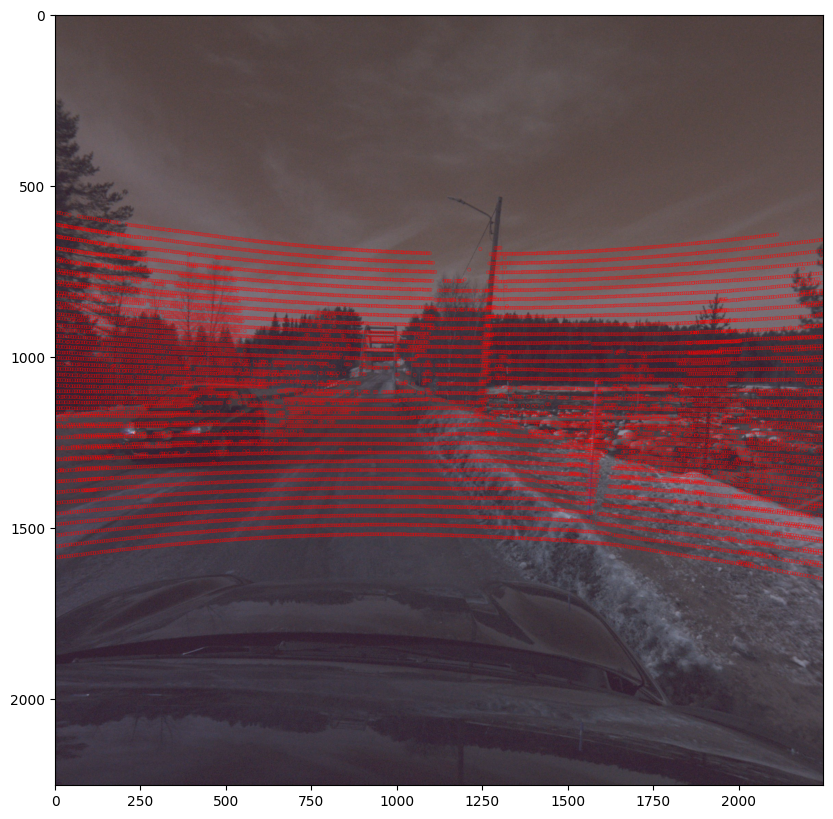

In [38]:
camera_image = cv2.imread('cam_0_49101816.jpg')
for x, y in pixel_pts_filtered :
    cv2.circle(camera_image, (x, y), 5, (255, 0, 0), 1)
    
plt.figure(figsize=(12,10))
plt.imshow(camera_image)

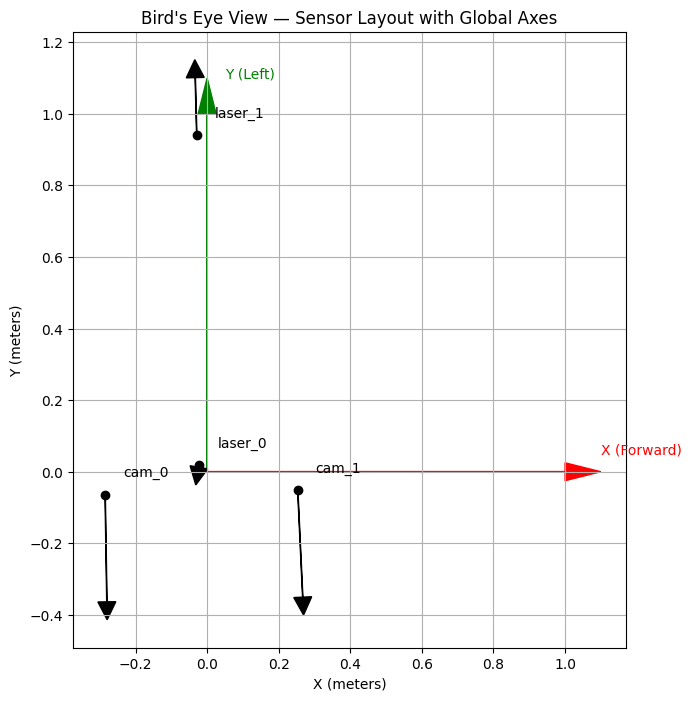

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

sensor_poses = {
    "cam_0": [-0.2848500567801104, -0.06362539090604688, -0.031160593085406987,
              0.002326408413228811, -0.009020361051359773, 0.7191082924435483, -0.6948355810185041],
    "cam_1": [0.2531755681297953, -0.05074859461390061, -0.029134358075553955,
              0.015055663316441308, -0.01783387338195476, 0.7162951698575746, -0.6974069899284111],
    "laser_0": [-0.02167014127808935, 0.019197187462634498, 0.08114620398614891,
                0.9999234510419756, 0.011293271828795937, -0.0020798363382534997, 0.004607423196635214],
    "laser_1": [-0.02900600225658079, 0.9404110366523747, 0.2669203147183163,
                1.2615640926260416e-05, -0.007217767641927124, 0.27885782390116315, 0.9603052731919266],
}

def draw_top_down(sensor_poses):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # Draw global coordinate axes
    origin = np.array([0.0, 0.0])
    ax.arrow(*origin, 1, 0, head_width=0.05, head_length=0.1, fc='red', ec='red')
    ax.text(1.1, 0.05, 'X (Forward)', color='red', fontsize=10)

    ax.arrow(*origin, 0, 1, head_width=0.05, head_length=0.1, fc='green', ec='green')
    ax.text(0.05, 1.1, 'Y (Left)', color='green', fontsize=10)

    for name, pose in sensor_poses.items():
        x, y = pose[0], pose[1]
        qw, qx, qy, qz = pose[3:]

        # Reorder for scipy
        r = R.from_quat([qx, qy, qz, qw])
        direction = r.apply([0, 0, 1])  # Z-forward in sensor frame
        dx, dy = direction[0], direction[1]

        # Plot sensor
        ax.plot(x, y, 'ko')  # black circle
        ax.arrow(x, y, dx * 0.3, dy * 0.3, head_width=0.05, head_length=0.05, fc='black', ec='black')
        ax.text(x + 0.05, y + 0.05, name, fontsize=10)

    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_title("Bird's Eye View — Sensor Layout with Global Axes")
    ax.grid(True)
    plt.show()

draw_top_down(sensor_poses)


In [53]:
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R

def pose_to_matrix(x, y, z, qw, qx, qy, qz):
    quat = [qx, qy, qz, qw]  # reorder for scipy
    rot = R.from_quat(quat).as_matrix()
    T = np.eye(4)
    T[:3, :3] = rot
    T[:3, 3] = [x, y, z]
    return T

def create_label_sphere(position, color, radius=0.05):
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
    sphere.paint_uniform_color(color)
    sphere.translate(position)
    return sphere

# Sensor poses
sensor_poses = {
    "rig": [0, 0, 0, 1, 0, 0, 0],
    "cam_0": [-0.28485005, -0.06362539, -0.03116059,
              0.00232640, -0.00902036, 0.71910829, -0.69483558],
    "cam_1": [0.25317557, -0.05074859, -0.02913436,
              0.01505566, -0.01783387, 0.71629517, -0.69740699],
}

color_map = {
    "rig": [1.0, 0.0, 0.0],     # Red
    "cam_0": [0.0, 1.0, 0.0],   # Green
    "cam_1": [0.0, 0.0, 1.0],   # Blue
}

frames_and_labels = []

for name, pose in sensor_poses.items():
    T = pose_to_matrix(*pose)

    # Add frame
    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)
    frame.transform(T)
    frames_and_labels.append(frame)

    # Add label as sphere
    label_pos = T[:3, 3] + np.array([0.05, 0.05, 0.05])  # slightly offset
    label = create_label_sphere(label_pos, color_map[name])
    frames_and_labels.append(label)

o3d.visualization.draw_geometries(frames_and_labels)
